In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt


In [6]:

def get_B(R, A, B, G, P):
    # Step 1: Get x and y coordinates of points
    x = P[0]
    y = P[1]

    # Initialize output
    Bout = 0
    # Update output, if needed

    for k in range(len(A)):
        # Making the boarder
        m1 = math.tan(math.pi/2 - float(A[k][0]))
        m2 = math.tan(math.pi/2 - float(A[k][1]))
        
        if y < m1*x - R and y >= m2*x - R:  # Checking if P is in Area k

            d = math.sqrt(x**2 + (y-(-R))**2)
            h = R - d
            Bout = float(B[k]) + float(G[k])*h
            break

 
    return Bout # Returning the magnetic field value a the point of P

In [13]:

def rot_matrix(alpha):
    R = np.array([[np.cos(alpha), -np.sin(alpha)],
        [np.sin(alpha), np.cos(alpha)]]) # Defining the rotation matrix in a clockwise direction
    return R


def next_point(bending_radius, P, D):
    """This function calculates the next point of P depending on its directional vector and bending radius"""

    s = 0.01 # Step size

   
    pc = np.matmul(rot_matrix(-math.pi/2), D) # Multiplying the two matrices together to get the vector going from the point to the center
    pc = bending_radius *pc 

    Cx = P[0]+pc[0]
    Cy = P[1]+pc[1]
    c = np.array([Cx, Cy])
   
    CP = np.subtract(P, c) # Subtracting the center from the point to find CP
    theta = s/bending_radius
  
    CP2 = np.matmul(rot_matrix(-theta), CP)
    P2 = np.add(c,CP2) # Adding the distance from the center of the circle with the coordinates of the center to find the coordinates of the new point

    PC2 = -CP2
    D2 = np.matmul(rot_matrix(math.pi/2), PC2)

    # Compute the magnitude of the vector
    magnitude = np.linalg.norm(D2) 
    # Normalize the vector
    D2 = D2/magnitude  

   # D2 = np.array(D2)

    return P2, D2   




def get_points(R, A, B, G, P, D, Energy, size):

    # Compute the magnitude of the vector for normalization
    magnitude = np.linalg.norm(D) 
    # Normalize the vector
    eps = 1e-10
    D = D/(magnitude+eps) # Normalizing the vector and adding a tiny constant to avoid division by zero error

    B_e = 3.3356*(Energy/1000) # Beam Rigidity
    s = 0.01 # Step size

    points = []
    points.append([float(P[0]), float(P[1])])

    trajectory_len = float(size)
    num_steps = trajectory_len/s

    bending_radnius = []
    for i in range(int(num_steps)):
        Bout = get_B(R, A, B, G, P)
        if Bout != 0:
            bending_rad = B_e/abs(Bout) # Radius
            bending_radnius.append(R)
            P, D = next_point(bending_rad,P,D) # Calculating the next point
        else: # If the magnetic field is zero at this point the particle just continues in a straight line
            P2 = s*D
            P = np.add(P, P2)

        points.append(P)
    
     
    # Splitting the data into x and y coordinates for plotting
    x = [point[0] for point in points]
    y = [point[1] for point in points]


    return x,y, bending_radnius



In [14]:
import math
import numpy as np
import matplotlib.pyplot as plt

def get_circle_coordinates(R, a, b, stepSize):
    positions = []
    t = 0
    while t < 2 * math.pi:
        positions.append((R*math.cos(t) + a, R*math.sin(t) + b))
        t += stepSize
    return positions

def create_plot(X, Y):
    fig, ax = plt.subplots(figsize=(10,10)) 
    ax.plot(X, Y, color='black')
    return fig, ax

def split_vectors(li):
    d = dict()
    for i in range(len(li[0])):
        d[i] = []
        for j in range(len(li)):
            try:
                d[i].append(li[j][i])
            except IndexError:
                d[i].append(0)
    B = d[0]
    G = d[1] if 1 in d else [0] * len(li)
    return B, G

def calculate_alpha_intervals(a):
    A = []
    curr = 0
    for i in range(len(a)):
        A.append([curr, curr + float(a[i])])
        curr += float(a[i])
    return A

def map_magnetic_field(X_min, X_max, Y_min, Y_max, R, A, B, G):
    X = np.linspace(X_min, X_max, num=100)
    Y = np.linspace(Y_min, Y_max, num=100)
    xx, yy = np.meshgrid(X, Y)
    mag_field = np.zeros_like(xx)

    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            P = xx[i, j], yy[i, j]
            mag_field[i, j] = get_B(R, A, B, G, P)

    return xx, yy, mag_field

def display_magnetic_fild(A, li, R):
    """ This function creates the default preview that the user can see without having to input X_min, X_max, Y_min, Y_max"""
    
    X_min, X_max, Y_min, Y_max = -0.2, R + 0.5, -R-0.2, 0.2
    a, b, stepSize = 0, -R, 0.01
    
    positions = get_circle_coordinates(R, a, b, stepSize)
    X = [x for x, y in positions]
    Y = [y for x, y in positions]

    fig, ax = create_plot(X, Y)
    B, G = split_vectors(li)
    A = calculate_alpha_intervals(A)
    xx, yy, mag_field = map_magnetic_field(X_min, X_max, Y_min, Y_max, R, A, B, G)

    color_mesh = ax.pcolormesh(xx, yy, mag_field, cmap='Reds')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    colorbar = plt.colorbar(color_mesh, ax=ax)
    colorbar.set_label('Magnetic Field (T)')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim([X_min, X_max])
    ax.set_ylim([Y_min, Y_max])
    
    directions = ["1, 0", "1, 0", "1, 0"]
    positions = ["0, 0", "0, 0","0, 0"]
    Energy = [100,120,140]

    for i in range(len(positions)):
        parts = positions[i].split(',')
        pos = [float(part) for part in parts]
        
        parts = directions[i].split(',')
        dir = [float(part) for part in parts]

        x, y, bending_radius = get_points(R, A, B, G, [pos[0],pos[1]], [dir[0],dir[1]], Energy[i], 4)   
        plt.plot(x, y)

    return fig, ax, bending_radius


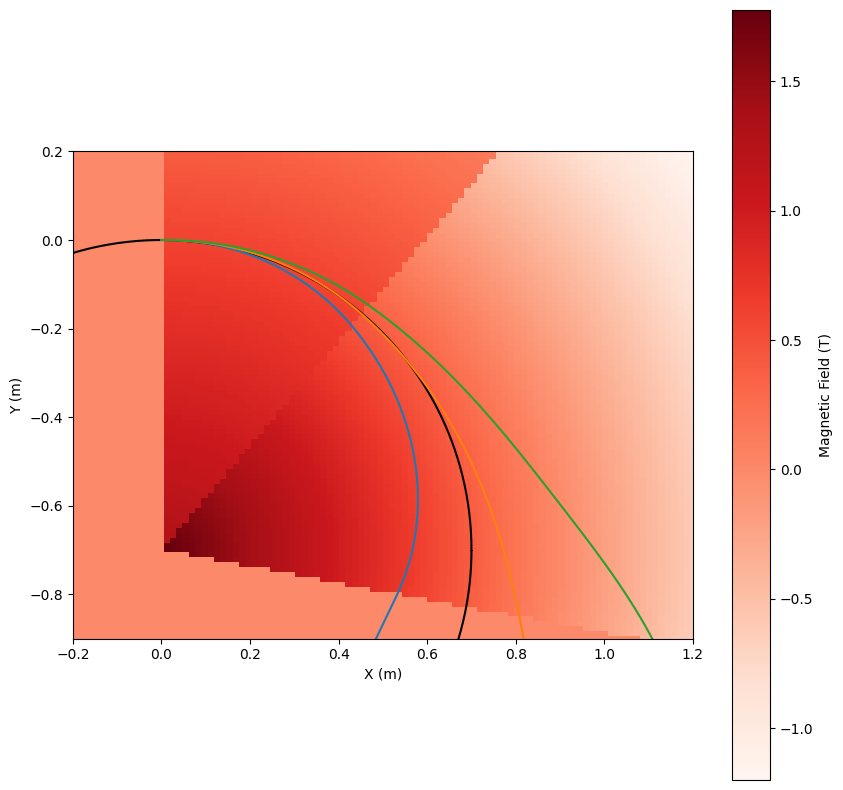

In [16]:

li = [[0.6, 1],[0.4, 2]]
A = [0.70220476, 1.05240451]
R = 0.7

fig,ax,bending_radius = display_magnetic_fild(A, li, R)